读懂本代码， 需要有所了解的前置教程：

* https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
* https://pandas.pydata.org/docs/user_guide/10min.html

<mark>**<font size=5>20240712   Test PPO</font>**</mark>

* gymnasium： https://gymnasium.farama.org/index.html
* 参考代码链接 1： https://zhiqingxiao.github.io/rl-book/en2024/code/Acrobot-v1_PPO_torch.html
* 参考代码链接 2： https://github.com/openai/spinningup/tree/master/spinup/algos/pytorch/ppo
* 参考代码链接 3：https://github.com/nikhilbarhate99/PPO-PyTorch/blob/master/PPO_colab.ipynb



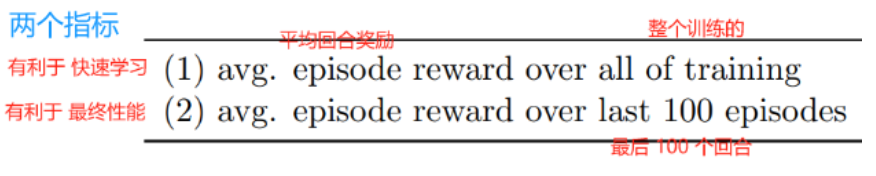

* 参考链接： https://arxiv.org/abs/1707.06347

------

- [x]  跑通
- [x] 注释， 和 伪码 以及 论文 对照
- [x] 增加 画图 和 可视化



Gym 库环境： CartPole-v1

测试效果： 100 个回合的平均奖励 不小于 <font color=red>**200**</font> 【 】；render 效果 【 】。


目标是让自由端在尽可能少的步骤中到达指定的目标高度。

* 坠毁 扣 100；正常着陆 +100

* 回合的奖励不少于 200， 则认为该回合的策略有效。

------



一些知识点：

### .unsqueeze(0)  和 .unsqueeze(1)

* https://pytorch.org/docs/2.3/generated/torch.unsqueeze.html#torch-unsqueeze


返回一个维度为 1 的新张量，**插入到指定位置**。

返回的张量与这个张量共享相同的底层数据。


dim = dim + input.dim() + 1

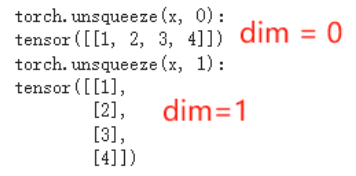

### 关于 detach

<mark>使用.detach()方法来确保这个tensor不会参与到后续的梯度计算中</mark>。


### 关于 torch.clamp

* https://pytorch.org/docs/2.3/generated/torch.clamp.html#torch.clamp




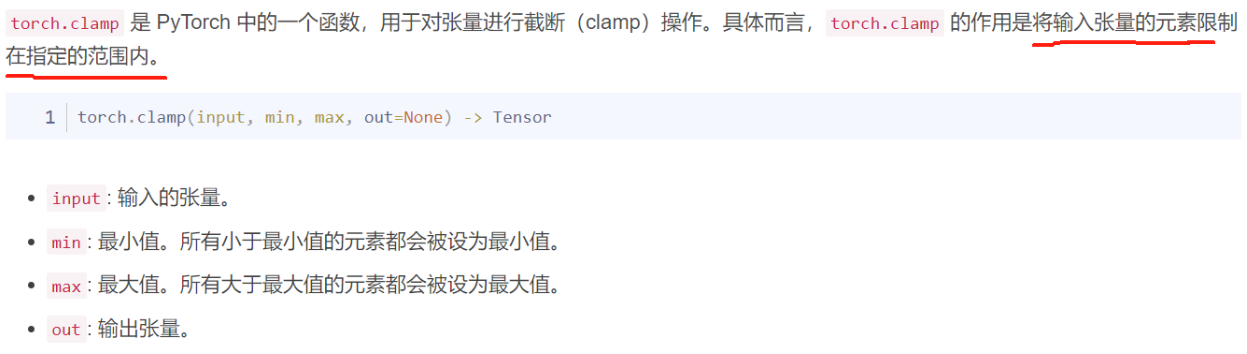

In [1]:
!pip install gymnasium  # 0.28.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 14.2 MB/s eta 0:00:00


In [2]:
# pip install gymnasium  # 0.28.1


%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import scipy.signal as signal
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
torch.manual_seed(0)

logging.basicConfig(level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

import warnings   # 忽略警告
warnings.filterwarnings("ignore")

In [ ]:
# !pip install gymnasium[box2d]

In [3]:
# 查看 仿真环境的信息

env = gym.make('CartPole-v1', render_mode='rgb_array')
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

# 重点关注信息：
# reward_threshold: -100.0
# max_episode_steps: 500

In [4]:
# 指标： 回合奖励参考阈值 查看

print(env.spec.reward_threshold)

# 测试时  100 个连续回合的平均奖励大于指定的值时，认为这个任务被解决了。
# ————肖智清《强化学习：原理与Python实战》

475.0


In [5]:

# 维护 agent 和 环境互动 的一些中间结果   集合 D_k

class PPOReplayer:
    def __init__(self):
        self.fields = ['state', 'action', 'prob', 'advantage', 'return']
        self.memory = pd.DataFrame(columns=self.fields)

    def store(self, df):
        self.memory = pd.concat([self.memory, df[self.fields]], ignore_index=True)

    def sample(self, size):
        indices = np.random.choice(self.memory.shape[0], size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.fields)

### .shift(-1)

* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html#pandas.DataFrame.shift




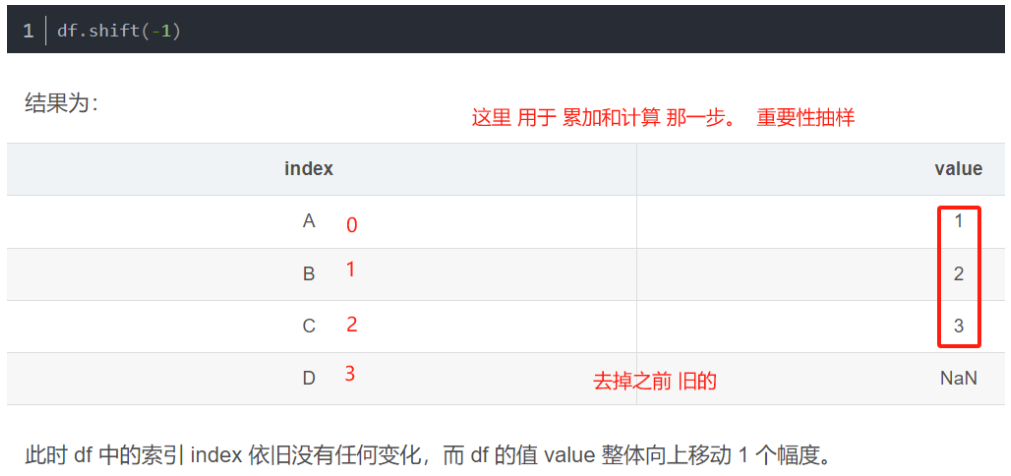

### 关于  scipy.signal.lfilter

* https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/ppo/core.py

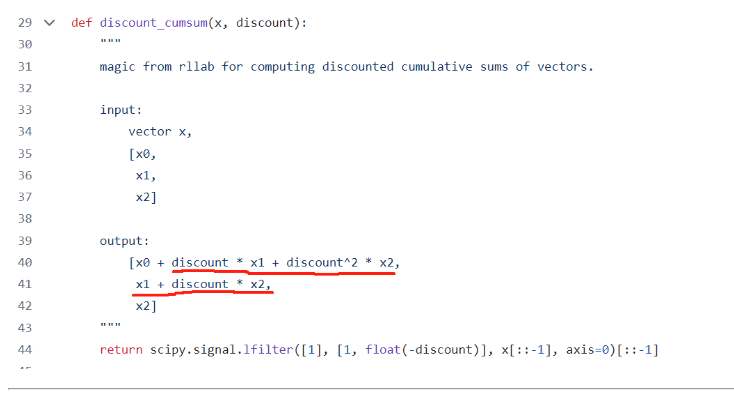




___________


* https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html#lfilter

这里用于 计算两个 多项式：

1、优势函数

$\hat A_t =\Delta_t+\gamma\Delta_{t+1}+\gamma^2\Delta_{t+2}+\cdots+\gamma^{T-t}\Delta_{T-t}+\gamma^{T-t+1}\Delta_{T-1} $

2、infinite-horizon discounted return

* Ref： https://spinningup.openai.com/en/latest/spinningup/rl_intro.html

$R(\tau)=\sum\limits_{t=0}^\infty{\gamma}^tr_t$




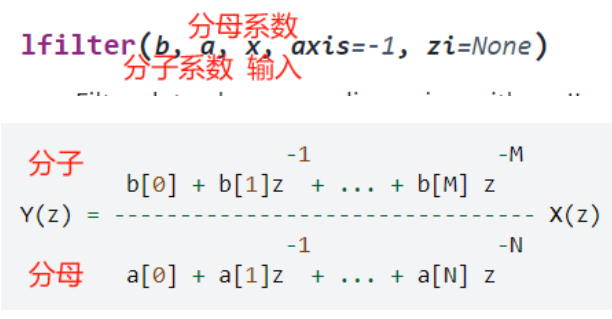

_________

为了 用 梯度下降， 原本求最大值， 加 负号后最小化

6：$~~~~~~$通过最大化 PPO-Clip 目标函数 更新策略：
$~~~~~~~~~~~$
$~~~~~~~~~~~\theta_{k+1}=\arg\max\limits_\theta\frac{1}{|{\cal D}_k|T}\sum\limits_{\tau\in{\cal D}_k}\sum\limits_{t=0}^T\min\Big(\frac{\pi_{\theta} (a_t|s_t)}{\pi_{\theta_k}(a_t|s_t)}A^{\pi_{\theta_k}}(s_t,a_t),g(\epsilon,A^{\pi_{\theta_k}}(s_t,a_t))\Big)$


——> $~~~~~~~\theta_{k+1}=\arg\min\limits_\theta\frac{1}{|{\cal D}_k|T}\sum\limits_{\tau\in{\cal D}_k}\sum\limits_{t=0}^T\min\Big(\frac{\pi_{\theta} (a_t|s_t)}{\pi_{\theta_k}(a_t|s_t)}·(-A^{\pi_{\theta_k}}(s_t,a_t)),g(\epsilon,-A^{\pi_{\theta_k}}(s_t,a_t))\Big)$


### 关于 categorical

* https://pytorch.org/docs/2.3/distributions.html#categorical




In [6]:
from torch.distributions import Categorical

m = Categorical(torch.tensor([ 0.25, 0.25, 0.25, 0.25 ]))
print(m.sample()) ## 0, 1, 2, 3 随机获取 tensor(3)  等概率获得
print(m.sample((2,)))  # 抽取其中 2 个样本

tensor(2)
tensor([0, 0])


In [7]:
m = Categorical(torch.tensor([ 0.2, 0.5, 0.3])) #
print(m.sample()) ## 类别索引为  0, 1, 2 随机获取 tensor(3)  等概率获得
print(m.sample((10,)))  # 抽取其中 2 个样本

tensor(0)
tensor([2, 1, 2, 0, 1, 1, 1, 1, 0, 1])


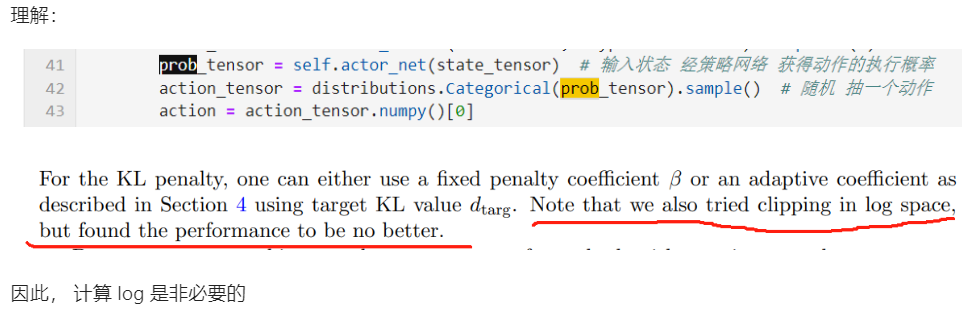

In [8]:

print(distributions.Categorical(torch.tensor([ 0.2, 0.5, 0.3])).sample().item())  # 随机 抽一个动作

# action_tensor = distributions.Categorical(torch.tensor([ 0.2, 0.5, 0.3])).sample()  # 随机 抽一个动作
# print(action_tensor.numpy()[0])

2


----

In [9]:
class PPOAgent:
    def __init__(self, env):
        self.gamma = 0.99  # 折扣因子 γ
        self.lambda0 = 0.95 # GAE 参数 λ
        self.clip_ratio = 0.1

        self.replayer = PPOReplayer()

        # 策略 参数  θ  状态 ——> 动作
        self.actor_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[100,],
                output_size=env.action_space.n, output_activator=nn.Softmax(1))
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), 0.001)

        # 值函数 参数 Φ
        self.critic_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[100,])
        self.critic_optimizer = optim.Adam(self.critic_net.parameters(), 0.002)  # 小数为学习率
        self.critic_loss = nn.MSELoss()  # 均方误差

    def build_net(self, input_size, hidden_sizes, output_size=1,
            output_activator=None):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        net = nn.Sequential(*layers)
        return net

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, terminated):
        state_tensor = torch.as_tensor(observation, dtype=torch.float).unsqueeze(0)
        prob_tensor = self.actor_net(state_tensor)  # 输入状态 经策略网络 获得动作的执行概率
        # action_tensor = distributions.Categorical(prob_tensor).sample()  # 随机 抽一个动作
        # action = action_tensor.numpy()[0]
        action = distributions.Categorical(prob_tensor).sample().item()
        if self.mode == 'train':
            self.trajectory += [observation, reward, terminated, action]
        return action

    def close(self):
        if self.mode == 'train':
            self.save_trajectory_to_replayer()
            if len(self.replayer.memory) >= 1000: ##  是否要改呢
                for _  in range(5):  # learn multiple times
                    self.learn()
                self.replayer = PPOReplayer()
                        # reset replayer after the agent changes itself

    def save_trajectory_to_replayer(self):
        df = pd.DataFrame(
                np.array(self.trajectory, dtype=object).reshape(-1, 4),
                columns=['state', 'reward', 'terminated', 'action'])
        state_tensor = torch.as_tensor(np.stack(df['state']), dtype=torch.float)
        action_tensor = torch.as_tensor(df['action'], dtype=torch.long)
        v_tensor = self.critic_net(state_tensor)
        df['v'] = v_tensor.detach().numpy()
        prob_tensor = self.actor_net(state_tensor)
        pi_tensor = prob_tensor.gather(-1, action_tensor.unsqueeze(1)).squeeze(1)
        df['prob'] = pi_tensor.detach().numpy() # 将数据 从计算图 中分离 并转成 numpy 数组
        df['next_v'] = df['v'].shift(-1).fillna(0.)  # 去掉最旧的， 最新的 填充为 0
        df['u'] = df['reward'] + self.gamma * df['next_v']  # 这一步 + 下一步 计算  Δt = r + γ V(s') - V(s)
        df['delta'] = df['u'] - df['v']
        df['advantage'] = signal.lfilter([1.,], [1., -self.gamma*self.lambda0],
                df['delta'][::-1])[::-1]  # ！ 【这里不太理解】 分子系数  分母系数  输入   改成最小化后 优势函数是负的，所以 gamma 取 负
        df['return'] = signal.lfilter([1.,], [1., -self.gamma],
                df['reward'][::-1])[::-1]  # critic 值函数 拟合 要用  return
        self.replayer.store(df)

    def learn(self):
        states, actions, old_pis, advantages, returns = \
                self.replayer.sample(size=64)
        state_tensor = torch.as_tensor(states, dtype=torch.float)
        action_tensor = torch.as_tensor(actions, dtype=torch.long)
        old_pi_tensor = torch.as_tensor(old_pis, dtype=torch.float)
        advantage_tensor = torch.as_tensor(advantages, dtype=torch.float)
        return_tensor = torch.as_tensor(returns, dtype=torch.float).unsqueeze(1)

        # update actor
        all_pi_tensor = self.actor_net(state_tensor)
        pi_tensor = all_pi_tensor.gather(1, action_tensor.unsqueeze(1)).squeeze(1)
        ratio = pi_tensor / old_pi_tensor
        clid_adv = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * advantage_tensor
        # surrogate_advantage_tensor = ratio * advantage_tensor # 第一项
        # clip_times_advantage_tensor = self.clip-ratio * surrogate_advantage_tensor  #  裁剪参数 ε = 0.1  clip-ratio
        # max_surrogate_advantage_tensor = advantage_tensor + \
        #         torch.where(advantage_tensor > 0.,
        #         clip_times_advantage_tensor, -clip_times_advantage_tensor) #  (1 + ε)A 或  (1 - ε)A
        # clipped_surrogate_advantage_tensor = torch.min(
        #         surrogate_advantage_tensor, max_surrogate_advantage_tensor)
        actor_loss_tensor = -(torch.min(ratio * advantage_tensor, clid_adv)).mean()  # 取负， 为了用梯度下降。相当于 除以 |D_k|*T  妙啊  这相当于 雨露均沾。但 每个 (s, a) 对 的重要性一般不一样。
        # self.actor_optimizer.zero_grad()
        actor_loss_tensor.backward()  # 反向传播 误差
        self.actor_optimizer.step() # 更新参数
        self.actor_optimizer.zero_grad() # 将梯度置零， 为下一轮优化做准备

        # update critic
        pred_tensor = self.critic_net(state_tensor)
        critic_loss_tensor = self.critic_loss(pred_tensor, return_tensor)
        # self.critic_optimizer.zero_grad()
        critic_loss_tensor.backward()
        self.critic_optimizer.step()
        self.critic_optimizer.zero_grad()


agent = PPOAgent(env)

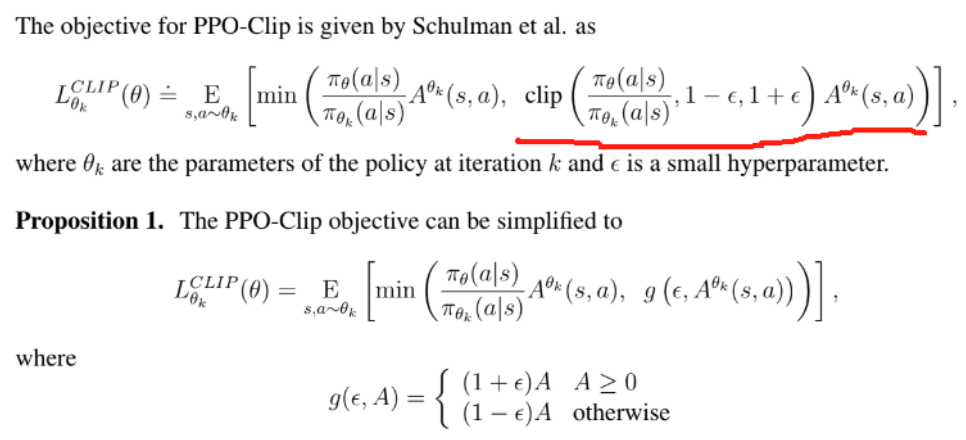

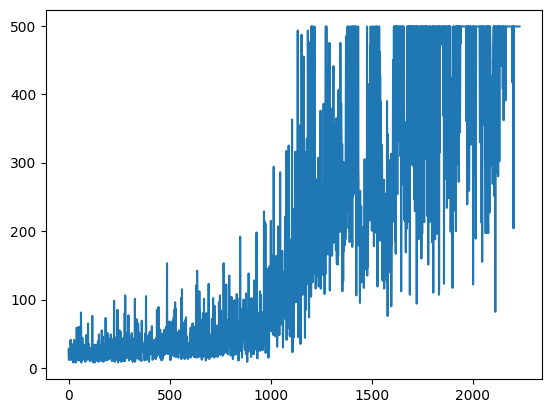

In [10]:
from IPython import display


def play_episode(env, agent, seed=None, mode=None, render=False, episode=None):
    observation, info = env.reset(seed=seed)
    reward, terminated, truncated = 0., False, False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    if not mode and episode == 99:  # 只可视化最后一个 episode
        img = plt.imshow(env.render()) # only call this once  # 可视化
    while True:
        action = agent.step(observation, reward, terminated)
        if render:
            env.render()
        # if terminated or truncated:
        #     break
        # Jupyter notebook  可视化 测试结果  仅显示 最后 3 个 回合
        if not mode and episode == 99:
            img.set_data(env.render()) # just update the data
            display.display(plt.gcf())
            display.clear_output(wait=True)

        observation, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
              break
        episode_reward += reward
        elapsed_steps += 1
    # 交互完成，是否训练
    agent.close()
    return episode_reward, elapsed_steps


def smooth(data, weight=0.9): # 平滑曲线 模块
    last = data[0]
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed  # 返回计算好的平滑数据


logging.info('================ train ================')
episode_rewards = []
for episode in itertools.count(): # 创建无限循环 itertools.count()
    episode_reward, elapsed_steps = play_episode(env, agent, seed=episode, mode='train')
    episode_rewards.append(episode_reward)
    logging.info('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-100:]) > 490:  # 原本 -120 后 100 个的奖励均值 大于 某个值 ，跳出 。一般来说这个值越大， 训练越久，测试时结果越好。权衡
        break


plt.plot(episode_rewards)
# plt.plot(smooth(episode_rewards), label='smoothed', linewidth=2.5, color='black')



# 预计 20 min

 !pip install seaborn

 画图 参考链接： https://seaborn.pydata.org/examples/errorband_lineplots.html
 https://seaborn.pydata.org/generated/seaborn.lineplot.html



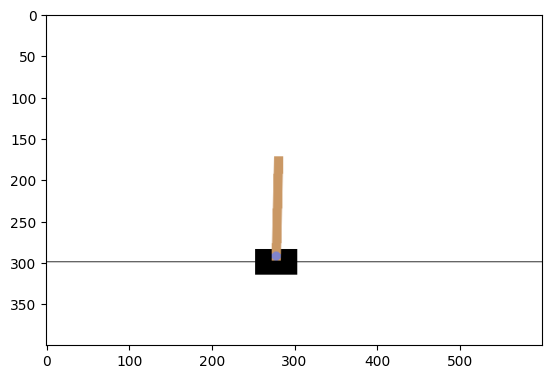

In [12]:
## 测试结果 查看

logging.info('================ test ================')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent, episode=episode)
    episode_rewards.append(episode_reward)
    logging.info('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

# plt.figure()
# plt.plot(episode_rewards, label='rewards', linewidth=1)
# plt.plot(smooth(episode_rewards), label='smoothed', linewidth=2.5,color='black')


env.close()